In [1]:
import numpy as np
from scipy import integrate    
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
sns.set_style("darkgrid")
pd.set_option('display.precision',1)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', '{:.2g}'.format)

from rsindy.rsindy_bayes import *
from argn_model import *
import argn_rsindy as argn

### Model
$$
\begin{align*}
    g + P_2 &\overset{k_1}{\to} gP_2 \\
    gP_2 &\overset{k_2}{\to} g + P_2 \\
    g &\overset{k_3}{\to} g + r \\
    r &\overset{k_4}{\to} r + P \\
    2P &\overset{k_5}{\to} P_2 \\
    P_2 &\overset{k_6}{\to} 2P \\
    r &\overset{k_7}{\to} \phi \\
    P &\overset{k_8}{\to} \phi 
\end{align*}
$$

which can be translated into

$$
\begin{align*}
    \frac{dg}{dt} &= k_2 gP2 - k_1 g P_2 \\
    \frac{dP_2}{dt} &= k_5 P^2 + k_2 gP2 - k_1 g P_2 - k_6 P_2\\
    \frac{dgP2}{dt} &= k_1 g P_2 - k_2 gP2 \\
    \frac{dr}{dt} &= k_3 g - k_7 r\\
    \frac{dP}{dt} &= k_4 r + 2 k_6 P_2 - 2 k_5 P^2 - k_8P\\
\end{align*}
$$

In [2]:
t = np.arange(0, 0.5, 0.05)
Z_obs, Z_obs_noisy = simulate_data(theta, t)

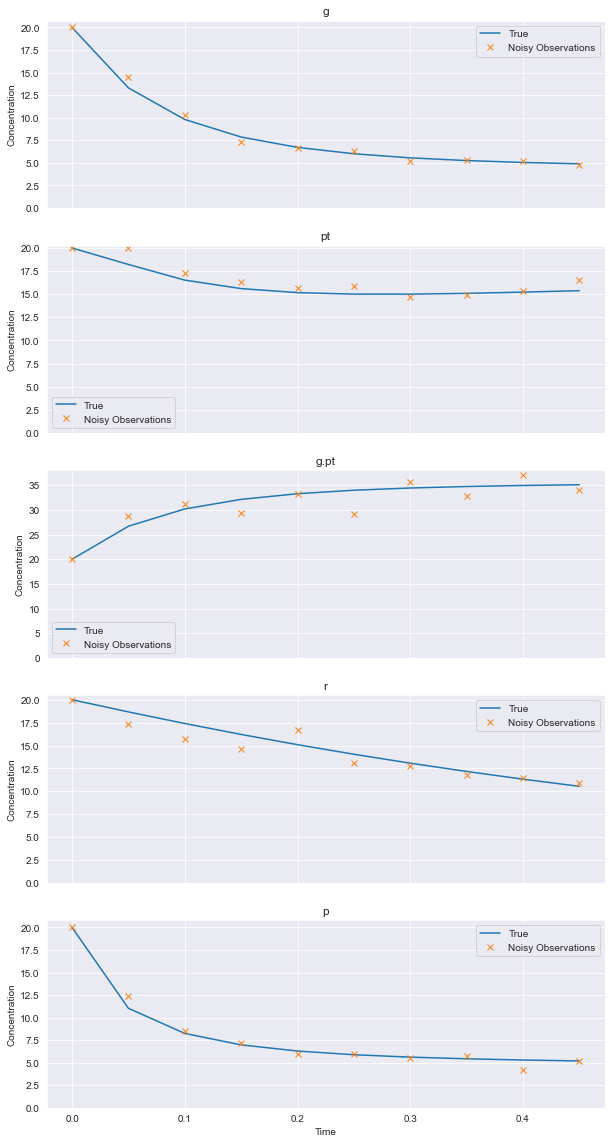

In [3]:
fig, ax = plt.subplots(5, 1, sharex=True)
for i in range(5):
    ax[i].plot(t, Z_obs[:,i], color = 'C0', label = 'True')
    ax[i].plot(t, Z_obs_noisy[:,i], 'x', color = 'C1', label = 'Noisy Observations')
    ax[i].legend()
    ax[i].set_title(species_names[i])
    ax[i].set_ylabel("Concentration")
    ax[i].set_ylim([0, None])
ax[4].set_xlabel("Time")
fig.set_size_inches(10, 20)
#plt.savefig("figures/argn_obs.png", dpi = 600)

## Latent-Variable with Horseshoe Prior (No Known Information)

In [4]:
bs_horseshoe = RSINDyRegularizedHorseshoe(species_names)

In [5]:
fit, _, S, R, D = bs_horseshoe.fit_non_dx(
                                X0 = Z_obs_noisy[0,:],
                                X_obs = Z_obs_noisy[1:,:],
                                ts = t,
                                known_S = Strue,
                                known_R = Rtrue,
                                known_rates = [],
                                N = 260 - 8,
                                regularized = True,
                                model_params = {
                                   'slab_scale' : 5,
                                   'slab_df' : 25,
                                   'tau0' : 1e-6,
                                   'noise_sigma' : 0.07
                                },
                                fit_params = {
                                   'chains' : 8,
                                    'iter_warmup' : 2000,
                                    'iter_sampling' : 500
                                    ,
                                    'show_progress' : 'notebook',
                                    'max_treedepth' : 8,
                                    'prior_predictive' : False
                                },
                                shuffle = False)   


INFO:cmdstanpy:compiling stan program, exe file: /private/var/folders/fr/mndzyyfj3077yvc2kyyr2l2r0000gn/T/tmp0ut79fcj
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /private/var/folders/fr/mndzyyfj3077yvc2kyyr2l2r0000gn/T/tmp0ut79fcj


Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 4 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 5 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 6 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 7 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 8 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

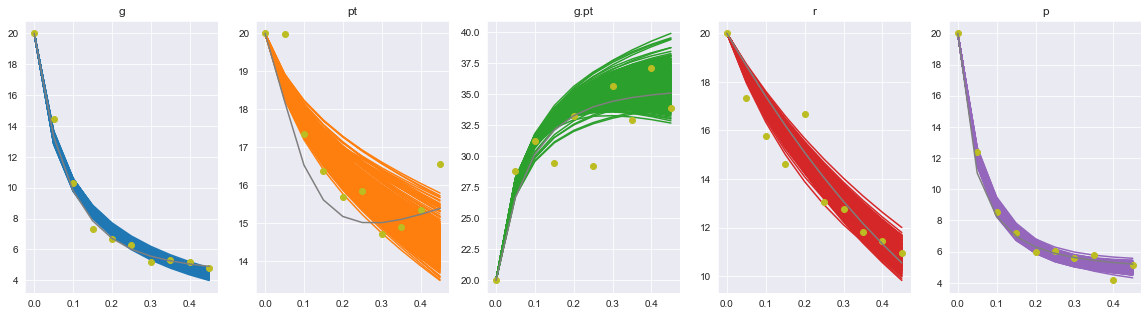

In [31]:
rates = fit.stan_variables()['rates'][0:500]
fig = bs_horseshoe.plot_simulated_trajectories(rates, S, R, [20, 20, 20, 20, 20], t)
fig.set_size_inches(20, 5)
for i in range(5):
    fig.axes[i].scatter(t, Z_obs_noisy[:,i], color = 'C8', zorder = 10)
    fig.axes[i].plot(t, Z_obs[:,i], color = 'C7', zorder = 10)

In [8]:
fit.sampler_variables()['lp__'].mean(axis = 0)

array([-776.999598, -783.610122, -787.73157 , -789.597616, -792.888726,
       -810.886916, -778.681108, -790.215342])

In [9]:
def prune_reactions_multi_chain(fit, samples_per_chain, chain_idx, known = [], threshold = 1e-3, pthresh = 0.9):
    rates = fit.stan_variables()['rates'][samples_per_chain * chain_idx:samples_per_chain * (chain_idx + 1)]
    tau = fit.stan_variables()['tau'][samples_per_chain * chain_idx:samples_per_chain * (chain_idx + 1)]
    lambda_tilde = fit.stan_variables()['lambda_tilde'][samples_per_chain * chain_idx:samples_per_chain * (chain_idx + 1)]
    probs = np.sum((lambda_tilde * tau.reshape(-1,1) > threshold), axis = 0)/tau.shape[0]
    return probs, known + [i + len(known) for i in np.where(probs > pthresh)[0]]

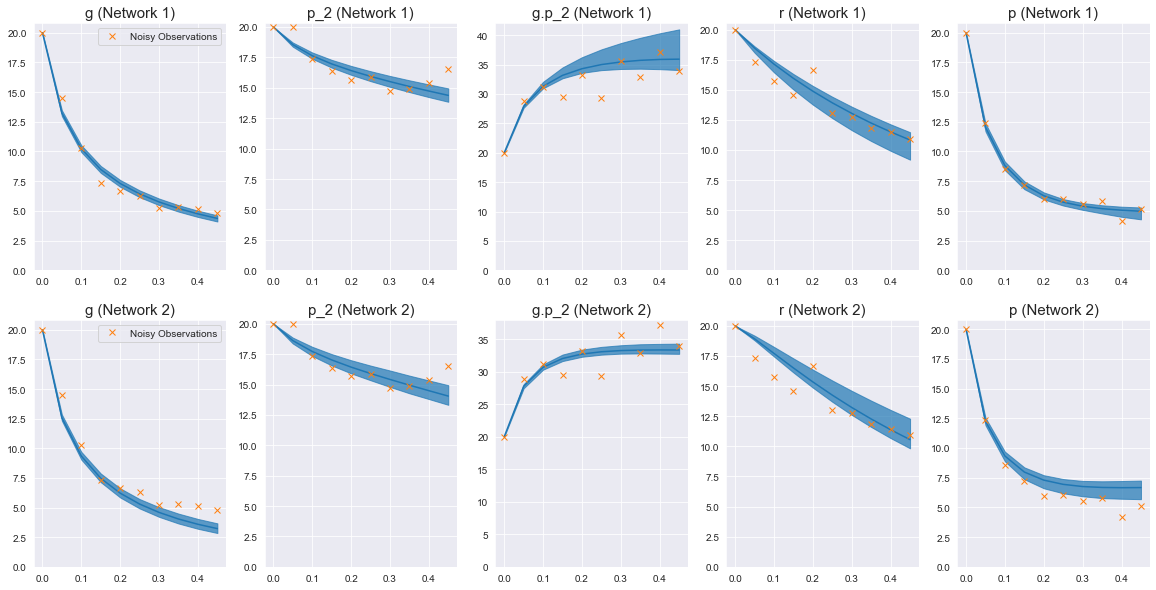

In [60]:
species_names_pres = ['g', 'p_2', 'g.p_2', 'r', 'p']
fig, ax = plt.subplots(2,5)
for l, j in enumerate([0,6]):
    p, r = prune_reactions_multi_chain(fit, 500, j)
    samples = fit.stan_variables()['rates']
    samples[:,[i for i in range(samples.shape[1]) if i not in r]] = 0
    Z_est_all = []
    for i in range(500):
        Z_est = solve_estimated_dynamics(samples[500 * (j) + i,:], S, R, [20, 20, 20, 20, 20], t)
        Z_est_all.append(Z_est)
    pct_20 = np.percentile(Z_est_all, 5, axis = 0)
    pct_50 = np.percentile(Z_est_all, 50, axis = 0)
    pct_80 = np.percentile(Z_est_all, 95, axis = 0)
    for k in range(5):
        ax[l][k].plot(t, pct_50[:,k], color = 'C0', alpha = 1)
        ax[l][k].fill_between(t, pct_20[:,k], pct_80[:,k], color = 'C0', alpha = 0.7)
        
    for k in range(5):
        ax[l][k].set_title("%s (Network %d)" % (species_names_pres[k], l + 1), fontsize = 15)
        ax[l][k].plot(t, Z_obs_noisy[:,k], 'x', label = 'Noisy Observations', color = 'C1')
        ax[l][k].set_ylim([0, None])

    ax[l][0].legend()
    

fig.set_size_inches(20, 10)
plt.savefig("results/figs/argn_full_recovered_trajectories.png", dpi = 400)

## Known Information

In [6]:
fit_known, _, S_known, R_known, D_known = bs_horseshoe.fit_non_dx(
                                X0 = Z_obs_noisy[0,:],
                                X_obs = Z_obs_noisy[1:,:],
                                ts = t,
                                known_S = Strue,
                                known_R = Rtrue,
                                known_rates = theta[:4],
                                N = 260 - 8,
                                regularized = True,
                                model_params = {
                                   'slab_scale' : 5,
                                   'slab_df' : 25,
                                   'tau0' : 1e-6,
                                   'noise_sigma' : 0.07
                                },
                                fit_params = {
                                   'chains' : 8,
                                    'iter_warmup' : 2000,
                                    'iter_sampling' : 500
                                    ,
                                    'show_progress' : 'notebook',
                                    'max_treedepth' : 8,
                                    'prior_predictive' : False
                                },
                                shuffle = False)   



INFO:cmdstanpy:compiling stan program, exe file: /private/var/folders/fr/mndzyyfj3077yvc2kyyr2l2r0000gn/T/tmpoqhg2j3z
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /private/var/folders/fr/mndzyyfj3077yvc2kyyr2l2r0000gn/T/tmpoqhg2j3z


Chain 1 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 2 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 3 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 4 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 5 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 6 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 7 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

Chain 8 - warmup:   0%|          | 0/1 [00:00<?, ?it/s]

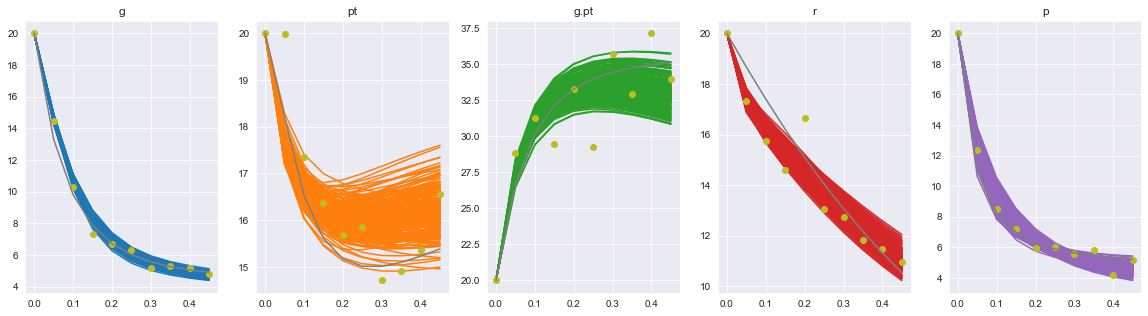

In [34]:
rates = fit_known.stan_variables()['rates'][0:200]
fig = bs_horseshoe.plot_simulated_trajectories(rates, S, R, [20, 20, 20, 20, 20], t, thresh = 1e-3)
fig.set_size_inches(20, 5)
for i in range(5):
    fig.axes[i].scatter(t, Z_obs_noisy[:,i], color = 'C8', zorder = 10)
    fig.axes[i].plot(t, Z_obs[:,i], color = 'C7', zorder = 10)

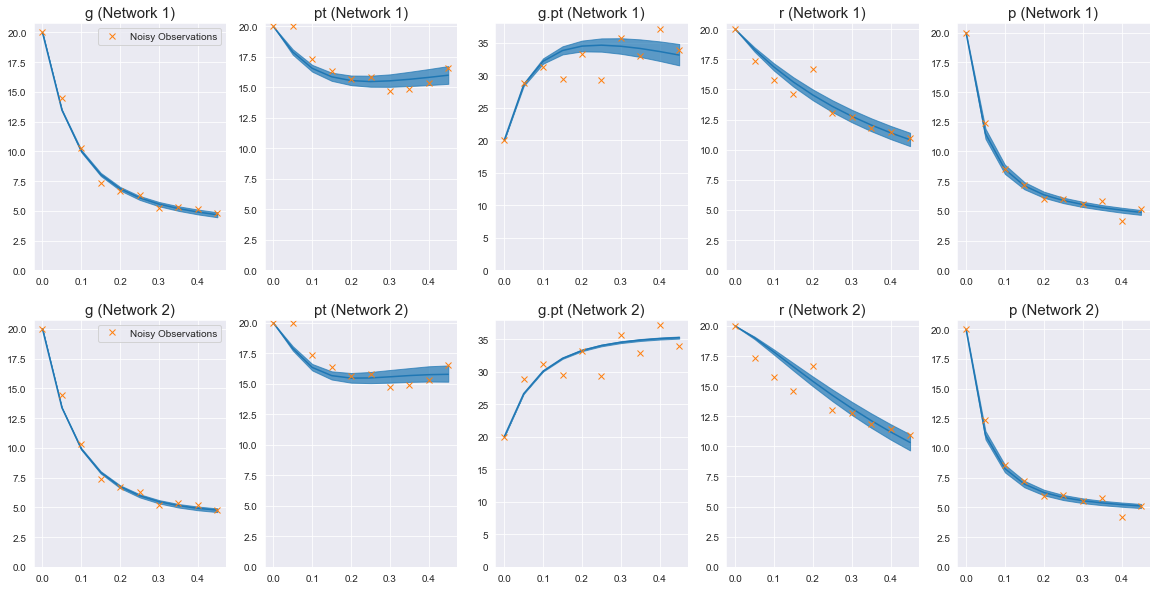

In [55]:
fig, ax = plt.subplots(2,5)
for l, j in enumerate([1, 3]):
    p, r = prune_reactions_multi_chain(fit_known, 500, j, known = [0, 1, 2, 3])
    samples = fit_known.stan_variables()['rates']
    samples[:,[i for i in range(samples.shape[1]) if i not in r]] = 0
    Z_est_all = []
    for i in range(500):
        Z_est = solve_estimated_dynamics(samples[500 * (j) + i,:], S, R, [20, 20, 20, 20, 20], t)
        Z_est_all.append(Z_est)
        
    pct_20 = np.percentile(Z_est_all, 5, axis = 0)
    pct_50 = np.percentile(Z_est_all, 50, axis = 0)
    pct_80 = np.percentile(Z_est_all, 95, axis = 0)
    for k in range(5):
        ax[l][k].plot(t, pct_50[:,k], color = 'C0', alpha = 1)
        ax[l][k].fill_between(t, pct_20[:,k], pct_80[:,k], color = 'C0', alpha = 0.7)

    for k in range(5):
        ax[l][k].set_title("%s (Network %d)" % (species_names_pres[k], l + 1), fontsize = 15)
        ax[l][k].plot(t, Z_obs_noisy[:,k], 'x', label = 'Noisy Observations', color = 'C1')
        ax[l][k].set_ylim([0, None])

    ax[l][0].legend()
    

fig.set_size_inches(20, 10)
plt.savefig("results/figs/argn_known_recovered_trajectories.png", dpi = 400)

## RSINDy Fit

In [56]:
argn.TIMESTEP = t[1] - t[0]
dcounts_dt_z_obs = argn.derivative(t, Z_obs_noisy)
result_gridsolve = argn.solve_grid(counts=Z_obs_noisy, dcounts_dt=dcounts_dt_z_obs, alphas=np.logspace(-5, -1, num=100), 
                                 l1_ratios=np.linspace(0, 1, 10), njobs=1)
alphas_gs = np.array([res[0] for res in result_gridsolve])
sort = np.argsort(alphas_gs)
alphas_gs = alphas_gs[sort]
estimated_rates_gs = np.array([res[2] for res in result_gridsolve])
estimated_rates_gs = estimated_rates_gs[sort]
l1_errs_gs = np.sum(np.abs(estimated_rates_gs - argn.RATES), axis=1)
best_estimated_rates_gs = estimated_rates_gs[np.argmin(l1_errs_gs)]

Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1e-05, lambda=0.0)!
status 0: Optimization terminated successfully
39 / 30000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1e-05, lambda=0.1111111111111111)!
status 0: Optimization terminated successfully
48 / 30000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1e-05, lambda=0.2222222222222222)!
status 0: Optimization terminated successfully
40 / 30000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1e-05, lambda=0.3333333333333333)!
status 0: Optimization terminated successfully
76 / 30000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1e-05, lambda=0.4444444444444444)!
status 0: Optimization terminated successfully
52 / 30000 iterations
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1e-05, lambda=0.5555555555555556)!
status 0: Optimization

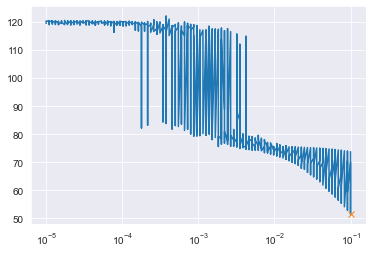

In [57]:
plt.semilogx(alphas_gs, l1_errs_gs)
plt.plot([alphas_gs[np.argmin(l1_errs_gs)]], [l1_errs_gs[np.argmin(l1_errs_gs)]], 'x')

In [58]:
Z_est_rsindy = solve_estimated_dynamics(best_estimated_rates_gs, S, R, [20, 20, 20, 20, 20], t)

## Plots

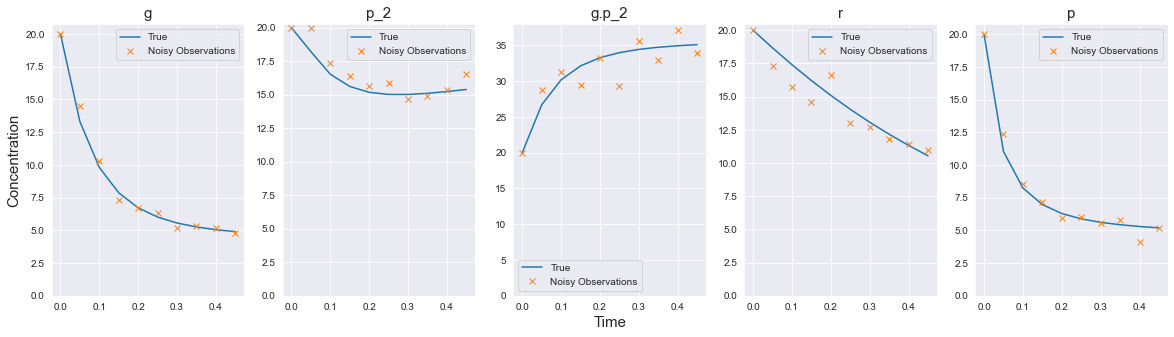

In [61]:
fig, ax = plt.subplots(1, 5)

for i in range(5):
    ax[i].plot(t, Z_obs[:,i], color = 'C0', label = 'True')
    ax[i].plot(t, Z_obs_noisy[:,i], 'x', color = 'C1', label = 'Noisy Observations')
    ax[i].legend()
    ax[i].set_title(species_names_pres[i], fontsize = 15)
    ax[i].set_ylim([0, None])
ax[0].set_ylabel("Concentration", fontsize = 15)
ax[2].set_xlabel("Time", fontsize = 15)
fig.set_size_inches(20, 5)
plt.savefig("results/figs/argn_obs.png", dpi = 400)

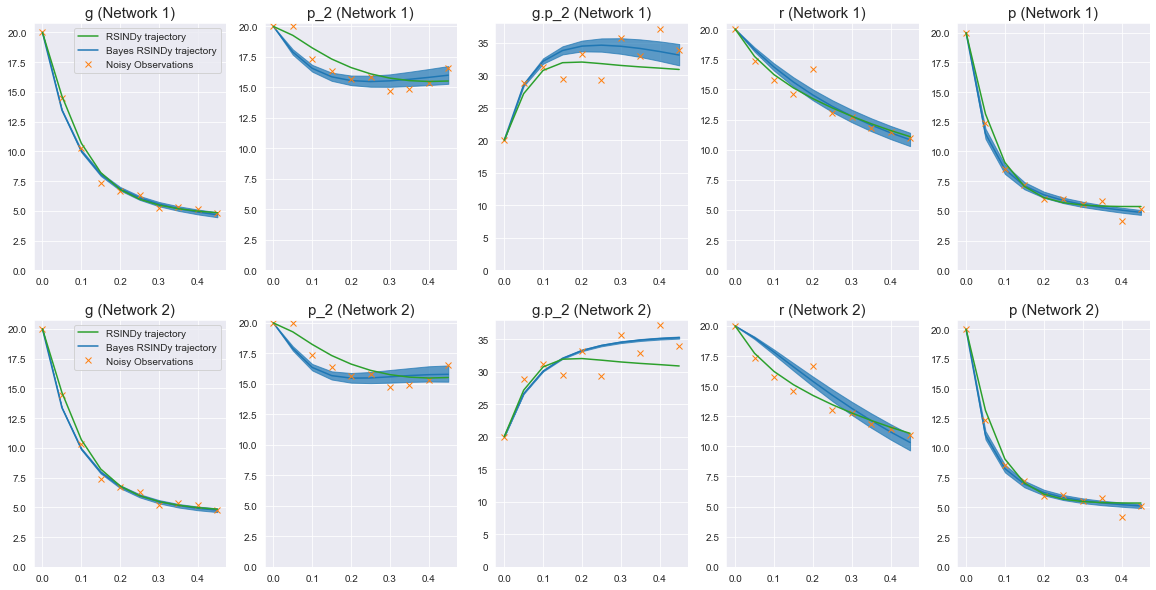

In [70]:
species_names_pres = ['g', 'p_2', 'g.p_2', 'r', 'p']
Z_est_rsindy = solve_estimated_dynamics(best_estimated_rates_gs, S, R, [20, 20, 20, 20, 20], t)
fig, ax = plt.subplots(2,5)
for i in range(5):
    ax[0][i].plot(t, Z_est_rsindy[:,i], color = 'C2', zorder = 10, label = 'RSINDy trajectory')
    ax[1][i].plot(t, Z_est_rsindy[:,i], color = 'C2', zorder = 10, label = 'RSINDy trajectory')
for l, j in enumerate([1,3]):
    p, r = prune_reactions_multi_chain(fit_known, 500, j, known = [0, 1, 2, 3])
    samples = fit_known.stan_variables()['rates']
    samples[:,[i for i in range(samples.shape[1]) if i not in r]] = 0
    Z_est_all = []
    for i in range(500):
        Z_est = solve_estimated_dynamics(samples[500 * (j) + i,:], S, R, [20, 20, 20, 20, 20], t)
        Z_est_all.append(Z_est)
    pct_20 = np.percentile(Z_est_all, 5, axis = 0)
    pct_50 = np.percentile(Z_est_all, 50, axis = 0)
    pct_80 = np.percentile(Z_est_all, 95, axis = 0)
    for k in range(5):
        if k == 0:
            ax[l][k].plot(t, pct_50[:, k], color = 'C0', label = 'Bayes RSINDy trajectory', alpha = 1);
        else:
            ax[l][k].plot(t, pct_50[:,k], color = 'C0', alpha = 1)
        ax[l][k].fill_between(t, pct_20[:,k], pct_80[:,k], color = 'C0', alpha = 0.7)
        
    for k in range(5):
        ax[l][k].set_title("%s (Network %d)" % (species_names_pres[k], l + 1), fontsize = 15)
        ax[l][k].plot(t, Z_obs_noisy[:,k], 'x', label = 'Noisy Observations', color = 'C1')
        ax[l][k].set_ylim([0, None])

    ax[l][0].legend()
    

fig.set_size_inches(20, 10)
plt.savefig("results/figs/argn_known_recovered_trajectories.png", dpi = 400)

0.0
0.0


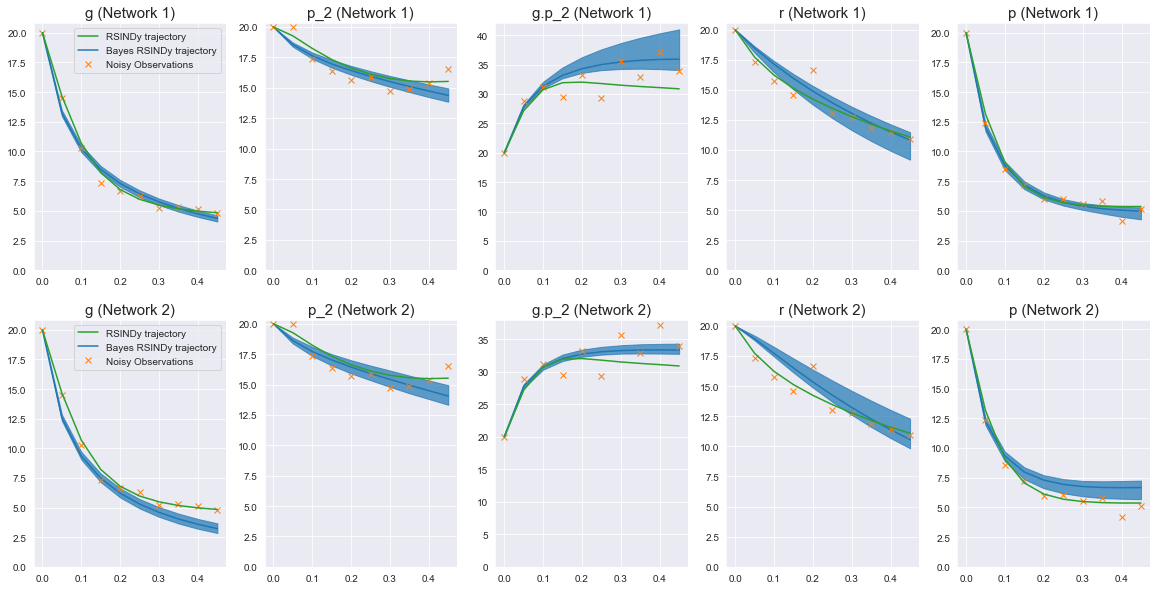

In [167]:
species_names_pres = ['g', 'p_2', 'g.p_2', 'r', 'p']
Z_est_rsindy = solve_estimated_dynamics(best_estimated_rates_gs, S, R, [20, 20, 20, 20, 20], t)
fig, ax = plt.subplots(2,5)
for i in range(5):
    ax[0][i].plot(t, Z_est_rsindy[:,i], color = 'C2', zorder = 10, label = 'RSINDy trajectory')
    ax[1][i].plot(t, Z_est_rsindy[:,i], color = 'C2', zorder = 10, label = 'RSINDy trajectory')
for l, j in enumerate([0,6]):
    p, r = prune_reactions_multi_chain(fit, 500, j)
    samples = fit.stan_variables()['rates']
    samples[:,[i for i in range(samples.shape[1]) if i not in r]] = 0
    print(samples[:,0].sum())
    Z_est_all = []
    for i in range(500):
        Z_est = solve_estimated_dynamics(samples[500 * (j) + i,:], S, R, [20, 20, 20, 20, 20], t)
        Z_est_all.append(Z_est)
    pct_20 = np.percentile(Z_est_all, 5, axis = 0)
    pct_50 = np.percentile(Z_est_all, 50, axis = 0)
    pct_80 = np.percentile(Z_est_all, 95, axis = 0)
    for k in range(5):
        if k == 0:
            ax[l][k].plot(t, pct_50[:, k], color = 'C0', alpha = 1, label = 'Bayes RSINDy trajectory');
        else:
            ax[l][k].plot(t, pct_50[:,k], color = 'C0', alpha = 1)
        ax[l][k].fill_between(t, pct_20[:,k], pct_80[:,k], color = 'C0', alpha = 0.7)
        
    for k in range(5):
        ax[l][k].set_title("%s (Network %d)" % (species_names_pres[k], l + 1), fontsize = 15)
        ax[l][k].plot(t, Z_obs_noisy[:,k], 'x', label = 'Noisy Observations', color = 'C1')
        ax[l][k].set_ylim([0, None])

    ax[l][0].legend()
    

fig.set_size_inches(20, 10)
plt.savefig("results/figs/argn_full_recovered_trajectories.png", dpi = 400)

In [84]:
p, r = prune_reactions_multi_chain(fit_known, 500, 1, threshold=1e-3, known = [0, 1, 2, 3])

In [85]:
samples = fit_known.stan_variables()['rates']
samples[:,[i for i in range(samples.shape[1]) if i not in r]] = 0

In [88]:
np.where(samples[500:1000,:] > 0)

(array([  0,   0,   0, ..., 499, 499, 499]),
 array([  0,   1,   2, ..., 108, 180, 205]))

In [110]:
D_known[r[i]].replace("pt","p_2")

'g.p_2 + r -> p_2 + g.p_2'

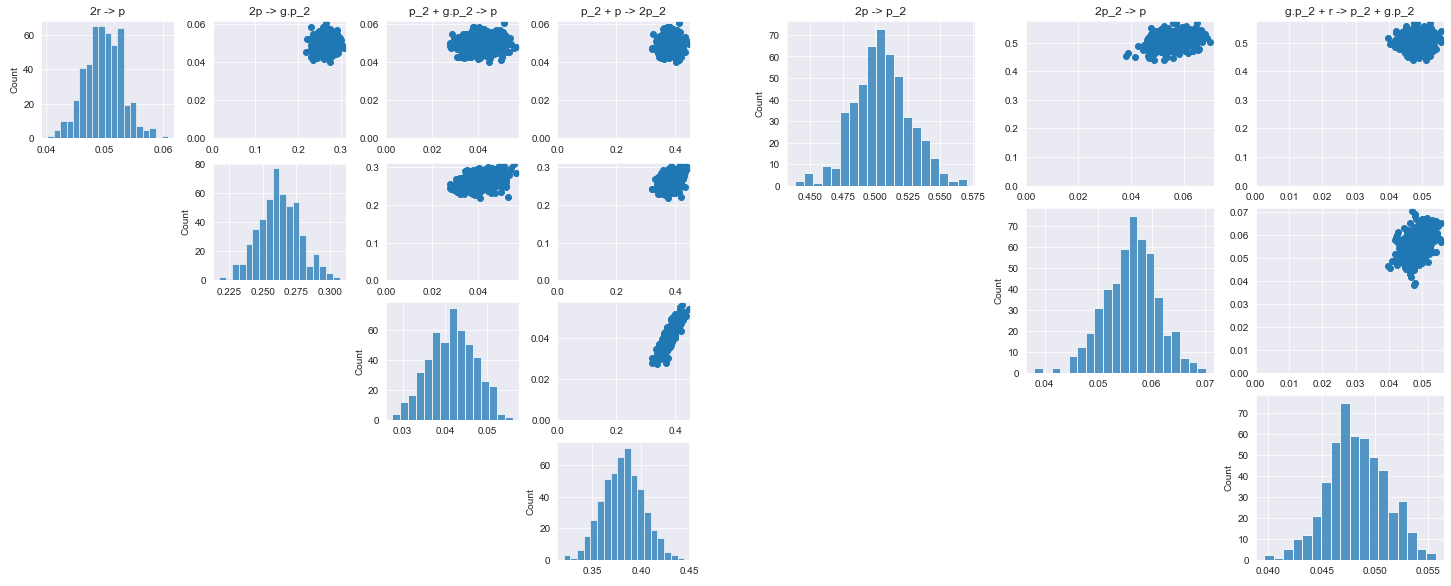

In [118]:
fig = plt.figure(constrained_layout=True, figsize=(20, 8))
subfigs = fig.subfigures(1, 2, wspace=0.07)
p, r = prune_reactions_multi_chain(fit_known, 500, 1, known = [0, 1, 2, 3])
samples = fit_known.stan_variables()['rates']
r = r[4:]
axl = subfigs[0].subplots(len(r), len(r))
for i in range(len(r)):   
    axl[0][i].set_title(D_known[r[i]].replace("pt","p_2"))
    for j in range(i, len(r)):
        if i == j:
            sns.histplot(samples[500 * 1:500 * 2,r[i]], bins = 'auto', color = 'C0', ax = axl[i][j]);
        else:
            axl[i][j].scatter(samples[500 * 1:500 * 2,r[j]], samples[500 * 1:500 * 2,r[i]], color = 'C0')
            axl[i][j].set_xlim([0, None])
            axl[i][j].set_ylim([0, None])

            axl[j][i].axis('off')

p, r = prune_reactions_multi_chain(fit_known, 500, 3, known = [0, 1, 2, 3])
samples = fit_known.stan_variables()['rates']
r = r[4:]
axr = subfigs[1].subplots(len(r), len(r))
for i in range(len(r)):   
    axr[0,i].set_title(D_known[r[i]].replace("pt","p_2"))
    for j in range(i, len(r)):
        if i == j:
            sns.histplot(samples[500 * 3:500 * 4,r[i]], bins = 'auto', color = 'C0', ax = axr[i][j]);
        else:
            axr[i][j].scatter(samples[500 * 3:500 * 4,r[j]], samples[500 * 3:500 * 4,r[i]], color = 'C0')
            axr[i][j].set_xlim([0, None])
            axr[i][j].set_ylim([0, None])

            axr[j][i].axis('off')

plt.savefig("results/figs/known_posteriors.png", dpi = 400)

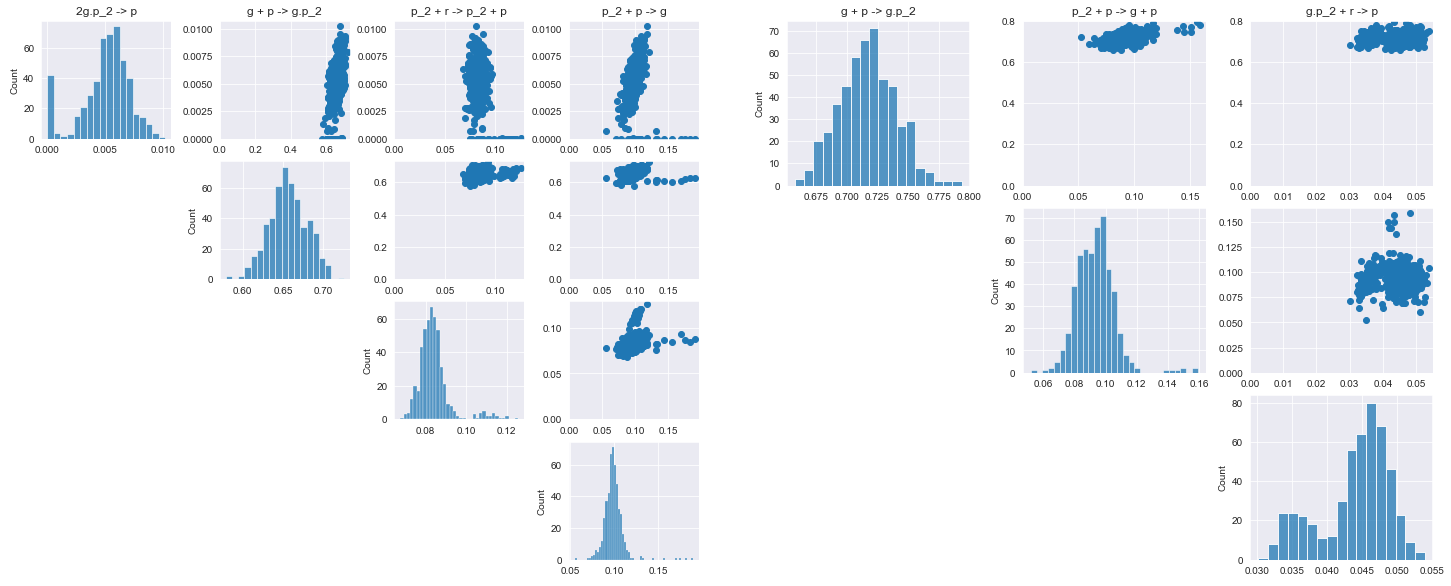

In [119]:
fig = plt.figure(constrained_layout=True, figsize=(20, 8))
subfigs = fig.subfigures(1, 2, wspace=0.07)
p, r = prune_reactions_multi_chain(fit, 500, 0)
samples = fit.stan_variables()['rates']
axl = subfigs[0].subplots(len(r), len(r))
for i in range(len(r)):   
    axl[0][i].set_title(D[r[i]].replace("pt","p_2"))
    for j in range(i, len(r)):
        if i == j:
            sns.histplot(samples[500 * 0:500 * 1,r[i]], bins = 'auto', color = 'C0', ax = axl[i][j]);
        else:
            axl[i][j].scatter(samples[500 * 0:500 * 1,r[j]], samples[500 * 0:500 * 1,r[i]], color = 'C0')
            axl[i][j].set_xlim([0, None])
            axl[i][j].set_ylim([0, None])

            axl[j][i].axis('off')

p, r = prune_reactions_multi_chain(fit, 500, 6)
samples = fit.stan_variables()['rates']
axr = subfigs[1].subplots(len(r), len(r))
for i in range(len(r)):   
    axr[0,i].set_title(D[r[i]].replace("pt","p_2"))
    for j in range(i, len(r)):
        if i == j:
            sns.histplot(samples[500 * 6:500 * 7,r[i]], bins = 'auto', color = 'C0', ax = axr[i][j]);
        else:
            axr[i][j].scatter(samples[500 * 6:500 * 7,r[j]], samples[500 * 6:500 * 7,r[i]], color = 'C0')
            axr[i][j].set_xlim([0, None])
            axr[i][j].set_ylim([0, None])

            axr[j][i].axis('off')

plt.savefig("results/figs/full_posteriors.png", dpi = 400)

In [163]:
_, r1 = prune_reactions_multi_chain(fit, 500, 0)
_, r2 = prune_reactions_multi_chain(fit, 500, 6)

In [165]:
samples = fit.stan_variables()['rates']
p_samples = [
    samples[0:500,r1],
    samples[3000:3500,r2]
]

for k, r in enumerate([r1,r2]):
    print("Reaction Network %d" % k)
    median_values = np.percentile(p_samples[k], 50, axis = 0)
    for i in range(p_samples[k].shape[1]):
        print("%d %f: %s" % (i + 1, median_values[i], D[r[i]].replace("pt","p_2")))

Reaction Network 0
1 0.005365: 2g.p_2 -> p
2 0.655190: g + p -> g.p_2
3 0.083120: p_2 + r -> p_2 + p
4 0.098495: p_2 + p -> g
Reaction Network 1
1 0.716942: g + p -> g.p_2
2 0.093182: p_2 + p -> g + p
3 0.045054: g.p_2 + r -> p


In [162]:
r1

[0, 1, 2, 3, 92, 108, 180, 205]

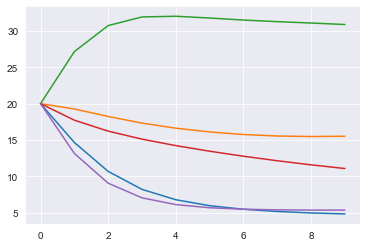

In [154]:
Z_est_rsindy = solve_estimated_dynamics(best_estimated_rates_gs, S, R, [20, 20, 20, 20, 20], t, thresh=2e-2)
plt.plot(Z_est_rsindy)

In [199]:
N = sum(best_estimated_rates_gs > 1e-2)
idxes = np.where(best_estimated_rates_gs > 1e-2)[0]
ss = []
for i in range(N):
    s = D[idxes[i]]
    s = s.replace("g.pt", "g P_2")
    s = s.replace("pt", "P2")
    s = s.replace("p", "P")
    s = s.replace("->","\overset{%.2f}{\\to}"% (best_estimated_rates_gs[idxes[i]]))
    ss.append("$" + s + "$")

In [202]:
print("\\\\".join(ss))

$g + P2 \overset{0.23}{\to} g P_2$\\$r \overset{4.66}{\to} 0$\\$g \overset{7.72}{\to} 0$\\$P2 \overset{6.27}{\to} 0$\\$g P_2 \overset{8.55}{\to} 2g P_2$\\$P \overset{1.05}{\to} P + P2$\\$P \overset{17.40}{\to} 2P$\\$g + P2 \overset{0.27}{\to} 2g$\\$g + g P_2 \overset{0.47}{\to} 2g P_2$\\$g + g P_2 \overset{0.05}{\to} r$\\$g + r \overset{0.40}{\to} 2g$\\$g + P \overset{0.03}{\to} P2$\\$g + P \overset{0.11}{\to} 2P$\\$P2 + g P_2 \overset{0.11}{\to} g$\\$P2 + g P_2 \overset{0.47}{\to} 2P2$\\$P2 + g P_2 \overset{0.14}{\to} P$\\$P2 + r \overset{0.18}{\to} 2r$\\$P2 + r \overset{0.05}{\to} P$\\$P2 + P \overset{0.71}{\to} 2P2$\\$g P_2 + r \overset{0.03}{\to} g$\\$g P_2 + r \overset{0.09}{\to} 2r$\\$g P_2 + P \overset{0.18}{\to} g$\\$g P_2 + P \overset{0.39}{\to} 2g P_2$\\$r + P \overset{0.25}{\to} 2r$
